#Глава 3

## Задание 3.1.

В примере с утечкой заменить окно Хэмминга одним из окон, предоставляемых NumPy, и посмотреть как оно влияет на утечку.

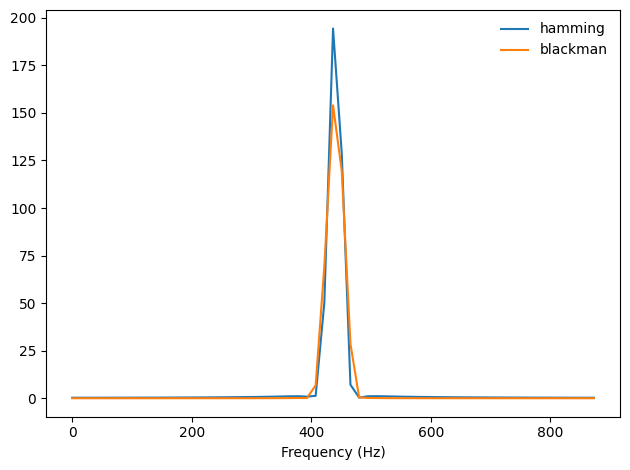

In [1]:
import numpy as np
from thinkdsp import decorate, SinSignal

signal = SinSignal(freq=440)
duration = signal.period * 30.25
wave = signal.make_wave(duration)
wave.hamming()
spectrum = wave.make_spectrum()
spectrum.plot(high=880, label=wave.hamming.__name__)


wave = signal.make_wave(duration)
wave.ys *= np.blackman(len(wave.ys))
spectrum = wave.make_spectrum()
spectrum.plot(high=880, label=np.blackman.__name__)

decorate(xlabel='Frequency (Hz)')

Из рисунка видно, что основная частота у Хэмминга видна лучше - пик уже и выше, у Блэкмана хуже разрешение, но меньше утечки - пик шире и чуть ниже.

## Задание 3.2.

Написать класс, называемый SawtoothChirp, расширяющий Chirp и переопределяющий evaluate для генерации пилообразного сигнала с линейно увеличивающейся (или уменьшающейся) частотой.

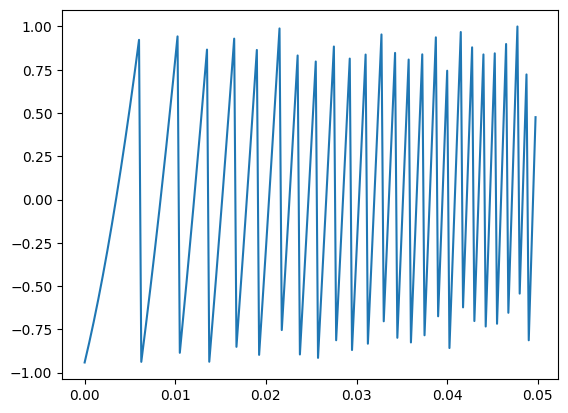

In [2]:
from thinkdsp import Chirp
from thinkdsp import normalize, unbias

PI2 = 2 * np.pi

class SawtoothChirp(Chirp):
    def evaluate(self, ts):
        freqs = np.linspace(self.start, self.end, len(ts))
        dts = np.diff(ts, prepend=0)
        dphis = 2 * np.pi * freqs * dts
        phases = np.cumsum(dphis)
        cycles = phases / (2 * np.pi)
        frac, _ = np.modf(cycles)
        ys = self.amp * normalize(unbias(frac))
        return ys
chirp = SawtoothChirp(start=110, end=880)
chirp_wave = chirp.make_wave(duration=0.05, framerate=4000)
chirp_wave.plot()

Продолжительность уменьшена для лучшей визуализации. Из графиак можно заметить, что сигнал выглядит как пила, частота которой постепенно растёт.



In [3]:
chirp_1 = SawtoothChirp(start=110, end=880)
chirp_wave_1 = chirp_1.make_wave(duration=2, framerate=4000)
chirp_wave_1.write("chirp.wav")

Writing chirp.wav


При прослушивании созданного сигнала можно услышать на низких частотах (начало) — грубый гудящий звук.
На высоких (конец) — более тонкий, но с биениями (пульсациями громкости).
Эффект похож на звук гоночного автомобиля или сирены, но с "пилообразным" тембром.

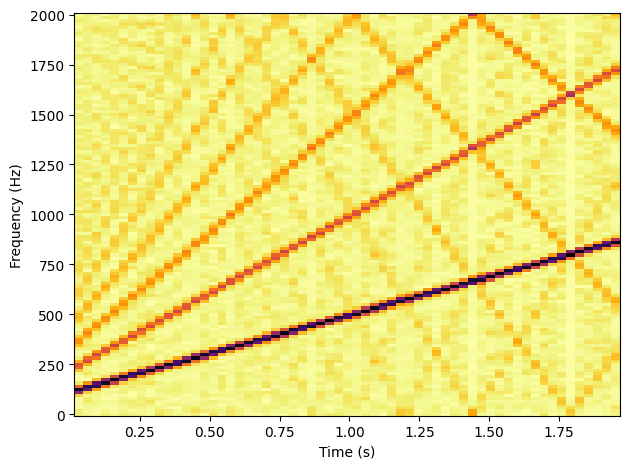

In [4]:
sp = chirp_wave_1.make_spectrogram(256)
sp.plot()
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

Из спектрограммы можно заметить, что гармоники пилообразного чирпа не параллельны, а расходятся веером из-за линейного роста основной частоты и умножения гармоник на n, что делает их наклон зависимым от номера гармоники.
А биения выглядят как волны или зигзаги вдоль линий гармоник. Это происходит за счет того, что когда гармоники приближаются к частоте сгибания, они "отражаются" назад, создавая зеркальные копии и эти отраженные гармоники интерферируют с основными.


## Задание 3.3.

Создать пилообразный чирп, меняющийся от 2500 до 3000 Гц, и на его основе сгенерировать сигнал 1 с и частотой кадров 20 кГц, сгенерировать сигнал и распечатать Spectrum.

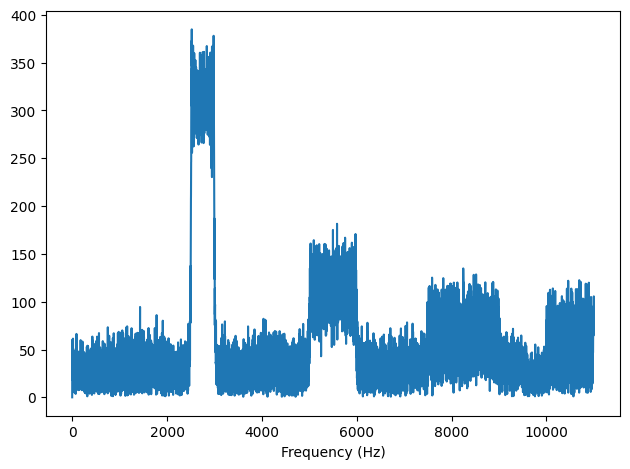

In [5]:
sawtooth_chirp = SawtoothChirp(start=2500, end=3000)
sawtooth_chirp_wave = sawtooth_chirp.make_wave(duration=1, framerate=22000)
sawtooth_chirp_wave.make_spectrum().plot()
decorate(xlabel='Frequency (Hz)')

Из графика можно заметить широкие полосы на частотах от 2500 до 3000 Гц (основная частота) и кратные им гармоники: 5000-6000 Гц (2-я), 7500-9000 Гц (3-я) и т.д. Спектр "размазанн" из-за изменения частоты, а гармоники убывают по амплитуде с ростом частоты.


В отличие от чистого тона, вместо четких пиков - широкие полосы частот, нет резкого обрыва на частоте Найквиста (10 кГц) и видна нелинейная зависимость амплитуд гармоник

## Задание 3.4.

Найти или записать звук глиссандо и распечатать спектрограмму первых нескольких секунд.

С сайта https://freesound.org/ был скачан и распечатан образец звука глиссандо.

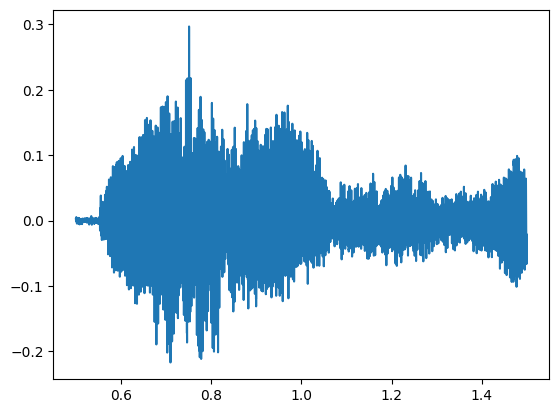

In [6]:
from thinkdsp import read_wave
filename = "431668__squidocto__cello-slides-bank-vault.wav"
gliss_wave = read_wave(filename)
start = 0.5
length = 1
segment_gliss = gliss_wave.segment(start, length)
segment_gliss.plot()

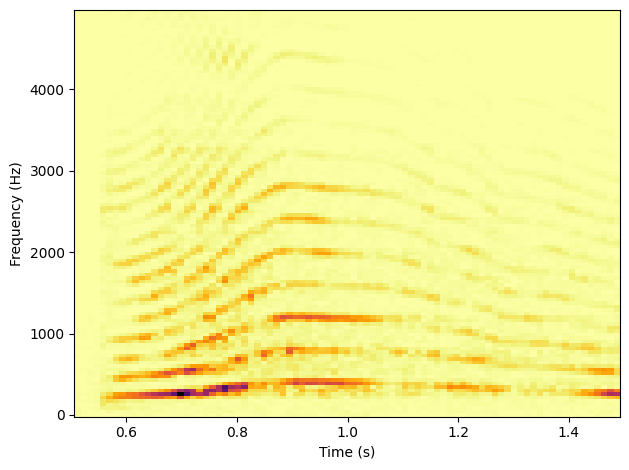

In [7]:
spp = segment_gliss.make_spectrogram(1024)
spp.plot(high=5000)
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

На спектрограмме видны основная частота (самая нижняя линия) и ее гармоники (линии выше основной частоты). Можно заметить, что гармоники имеют больший изгиб, это связано с тем, что они чувствительнее к изменениям натяжения, жёсткости струны и акустическим свойствам инструмента, чем основная частота.

## Задание 3.5.

Написать класс, называемый TromboneGliss, расширяющий Chirp и предоставляющий evaluate. Создать сигнал, имитирующий глиссандо на тромбоне от С3 до F3, и обратно до С3. Напечатать спектрограмму полученного сигнала.

In [8]:
from thinkdsp import Chirp
from thinkdsp import decorate
import numpy as np
class TromboneGliss(Chirp):
    def evaluate(self, ts):
        l1, l2 = 1.0 / self.start, 1.0 / self.end
        lengths = np.linspace(l1, l2, len(ts))
        freqs = 1 / lengths

        dts = np.diff(ts, prepend=0)
        dphis = 2 * np.pi * freqs * dts
        phases = np.cumsum(dphis)
        ys = self.amp * np.cos(phases)
        return ys
low = 262
high = 349
signal = TromboneGliss(high, low)
Trombone1 = signal.make_wave(duration=2)
Trombone1.apodize()

signal = TromboneGliss(low, high)
Trombone2 = signal.make_wave(duration=2)
Trombone2.apodize()

Trombone = Trombone1 | Trombone2
Trombone.write("Trombone.wav")

Writing Trombone.wav


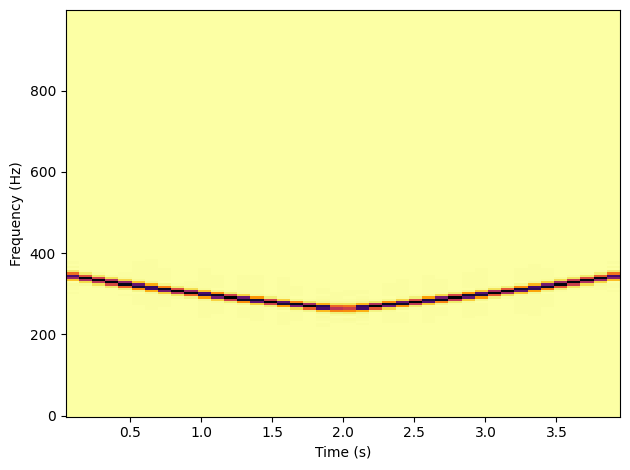

In [9]:
sppp = Trombone.make_spectrogram(2048)
sppp.plot(high=1000)
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

Визуально, глиссандо на тромбоне выглядит как экпоненциальный чирп, однако на данном графике это плохо видно. Немного изменим задание, для лучшей визуализации.

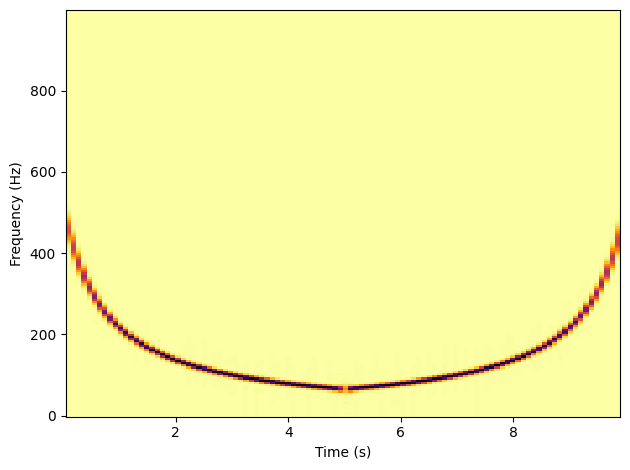

In [10]:
low = 65
high = 523
signal = TromboneGliss(high, low)
Trombone1 = signal.make_wave(duration=5)
Trombone1.apodize()

signal = TromboneGliss(low, high)
Trombone2 = signal.make_wave(duration=5)
Trombone2.apodize()

Trombone = Trombone1 | Trombone2
sppp = Trombone.make_spectrogram(2048)
sppp.plot(high=1000)
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

Теперь на графике более ярко видно, что глиссандо на тромбоне выглядит как экпоненциальный чирп.

## Задание 3.6.

Сделать или найти запись серии гласный звуков и посмотреть на спектрограмму.

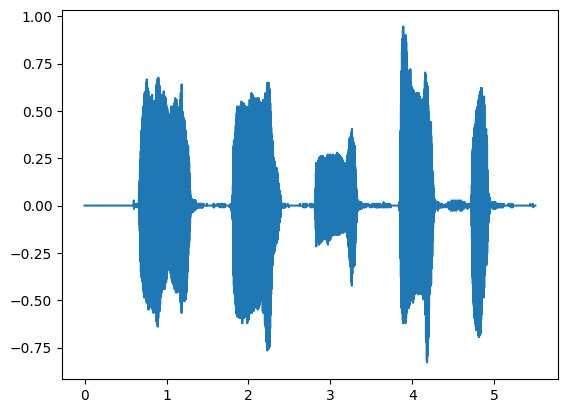

In [11]:
from thinkdsp import read_wave
filename = "523079__team_saul_nosthas__vowels-of-various-people.wav"
vowels_wave = read_wave(filename)
start = 0
length = 5.5
vowels_segment = vowels_wave.segment(start, length)
vowels_segment.plot()

In [12]:
vowels_segment.make_audio()

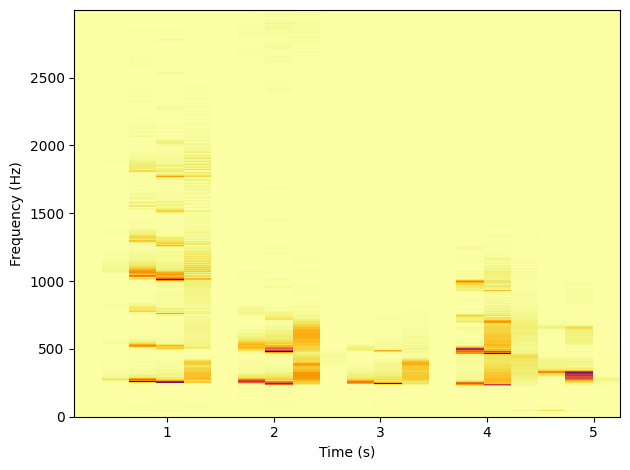

In [13]:
vowels_segment.make_spectrogram(4096).plot(high=3000)
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

Из спектрограммы видно, что самая высокая частота у звука "А", а самая низкая у звука "И".